# Experiment 1: Positional Encoding Visualization

## Theory

Transformers have no inherent notion of token order since self-attention operates on sets. **Positional Encoding (PE)** injects position information by adding learned or fixed position vectors to token embeddings.

The sinusoidal PE formula is:
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

**Key properties:**
- Even dimensions use sine, odd dimensions use cosine
- Lower dimensions encode slow-changing (long-range) patterns
- Higher dimensions encode fast-changing (local) patterns
- Relative positions are preserved: $PE_{pos+k}$ can be expressed as linear function of $PE_{pos}$

This experiment visualizes PE in low dimensions to build intuition.

In [4]:
import sys
sys.path.append('..')
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from modelling.positionalencoding import PositionalEncoding

plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

SINGLE_COL_WIDTH = 3.5
FIG_HEIGHT = 2.5

save_dir = '../figures/experiments/positional_encoding/'
os.makedirs(save_dir, exist_ok=True)

## Part A: Low-Dimensional PE Matrix

Create positional encoding with small dimensions to visualize the full matrix.

In [15]:
d_model = 8
max_len = 1000

pe = PositionalEncoding(d_model=d_model, max_len=max_len)
pe_matrix = pe.pe.squeeze(0).numpy()

print(f"PE Matrix shape: {pe_matrix.shape}")
print(f"First position encoding:\n{pe_matrix[0]}")
print(f"Second position encoding:\n{pe_matrix[1]}")

PE Matrix shape: (1000, 8)
First position encoding:
[0. 1. 0. 1. 0. 1. 0. 1.]
Second position encoding:
[0.84147096 0.54030234 0.09983341 0.9950042  0.00999983 0.99995
 0.001      0.9999995 ]


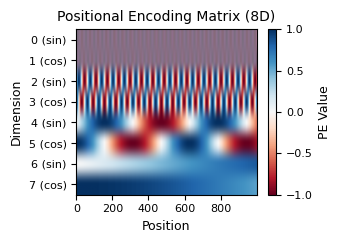

In [17]:
fig, ax = plt.subplots(figsize=(SINGLE_COL_WIDTH, FIG_HEIGHT))
im = ax.imshow(pe_matrix.T, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
ax.set_xlabel('Position')
ax.set_ylabel('Dimension')
ax.set_title('Positional Encoding Matrix (8D)')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('PE Value')

ax.set_yticks(range(d_model))
ax.set_yticklabels([f'{i} ({"sin" if i%2==0 else "cos"})' for i in range(d_model)])

plt.tight_layout()
plt.savefig(save_dir + 'pe_matrix_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_dir + 'pe_matrix_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Part B: Frequency Analysis

Plot individual dimensions over positions to show frequency differences.

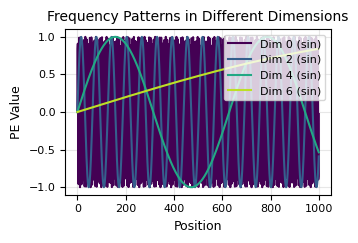

In [18]:
fig, ax = plt.subplots(figsize=(SINGLE_COL_WIDTH, FIG_HEIGHT))

positions = np.arange(max_len)
dims_to_plot = [0, 2, 4, 6]
colors = plt.cm.viridis(np.linspace(0, 0.9, len(dims_to_plot)))

for dim, color in zip(dims_to_plot, colors):
    ax.plot(positions, pe_matrix[:, dim], label=f'Dim {dim} (sin)', 
            linewidth=1.5, color=color)

ax.set_xlabel('Position')
ax.set_ylabel('PE Value')
ax.set_title('Frequency Patterns in Different Dimensions')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(save_dir + 'pe_frequency_analysis.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_dir + 'pe_frequency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Part C: 3D Position Space

Visualize positions in the first 3 dimensions of embedding space.

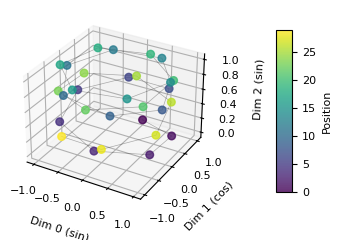

In [21]:
fig = plt.figure(figsize=(SINGLE_COL_WIDTH, SINGLE_COL_WIDTH))
ax = fig.add_subplot(111, projection='3d')

positions_to_show = 30
x = pe_matrix[:positions_to_show, 0]
y = pe_matrix[:positions_to_show, 1]
z = pe_matrix[:positions_to_show, 2]

scatter = ax.scatter(x, y, z, c=np.arange(positions_to_show), 
                     cmap='viridis', s=30, alpha=0.8)
ax.plot(x, y, z, 'k-', alpha=0.3, linewidth=0.5)

ax.set_xlabel('Dim 0 (sin)', fontsize=8)
ax.set_ylabel('Dim 1 (cos)', fontsize=8)
ax.set_zlabel('Dim 2 (sin)', fontsize=8)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, pad=0.2)
cbar.set_label('Position', fontsize=8)

plt.tight_layout()
plt.savefig(save_dir + 'pe_3d_space.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_dir + 'pe_3d_space.png', dpi=300, bbox_inches='tight')
plt.show()

## Part D: Position Similarity Matrix

Compute cosine similarity between all position pairs to show relative position encoding.

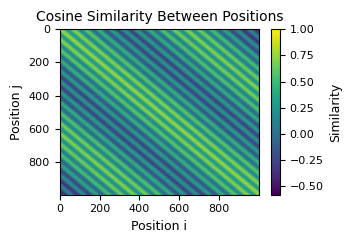

Similarity(pos=0, pos=1): 0.8838
Similarity(pos=0, pos=10): 0.4240
Similarity(pos=0, pos=49): 0.5921


In [22]:
pe_tensor = torch.tensor(pe_matrix)
pe_normalized = pe_tensor / pe_tensor.norm(dim=1, keepdim=True)
similarity_matrix = pe_normalized @ pe_normalized.T
similarity_np = similarity_matrix.numpy()

fig, ax = plt.subplots(figsize=(SINGLE_COL_WIDTH, FIG_HEIGHT))
im = ax.imshow(similarity_np, cmap='viridis', aspect='auto')
ax.set_xlabel('Position i')
ax.set_ylabel('Position j')
ax.set_title('Cosine Similarity Between Positions')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Similarity')
plt.tight_layout()
plt.savefig(save_dir + 'pe_similarity_matrix.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_dir + 'pe_similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Similarity(pos=0, pos=1): {similarity_np[0, 1]:.4f}")
print(f"Similarity(pos=0, pos=10): {similarity_np[0, 10]:.4f}")
print(f"Similarity(pos=0, pos=49): {similarity_np[0, 49]:.4f}")

## Key Takeaways

1. **Unique Signatures**: Each position gets a unique encoding vector
2. **Frequency Hierarchy**: Different dimensions capture different scales of position information
3. **Relative Position**: Similarity between positions depends on their distance $|i-j|$, not absolute positions
4. **Continuous Space**: Positions form a continuous trajectory in embedding space

These properties allow the transformer to learn both absolute and relative positional relationships through attention mechanisms.